In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        hidden = F.relu(self.fc1(x))
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z
    
    def decode(self, z):
        hidden = F.relu(self.fc2(z))
        reconstructed = torch.sigmoid(self.fc3(hidden))
        return reconstructed
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar

def loss_function(reconstructed, x, mean, logvar):
    # Reconstruction loss (binary cross-entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstructed, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = reconstruction_loss + kl_loss
    return total_loss

# Preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Example usage

# Parameters
input_dim = 784  # Dimension of input (28x28 pixels images in MNIST)
hidden_dim = 256  # Hidden dimension of encoder and decoder
latent_dim = 10  # Dimension of latent representation

# Create the VAE model
model = VAE(input_dim, hidden_dim, latent_dim)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
def train(model, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Prepare the data
            data = data.view(-1, input_dim)
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, mean, logvar = model(data)
            
            # Calculate the loss
            loss = loss_function(reconstructed, data, mean, logvar)
            
            # Backward pass and optimization
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            # Print training information
            if batch_idx % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))
        
        print('Epoch [{}/{}], Average Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss/len(train_loader)))

# Call the training function
num_epochs = 10
train(model, optimizer, num_epochs)


100%|██████████| 9912422/9912422 [00:07<00:00, 1260805.10it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


100%|██████████| 1648877/1648877 [00:01<00:00, 1296517.98it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch [1/10], Batch [1/469], Loss: 70227.3906
Epoch [1/10], Batch [101/469], Loss: -2365557.7500
Epoch [1/10], Batch [201/469], Loss: -2497822.7500
Epoch [1/10], Batch [301/469], Loss: -2744792.7500
Epoch [1/10], Batch [401/469], Loss: -2805517.7500
Epoch [1/10], Average Loss: -2540833.1669
Epoch [2/10], Batch [1/469], Loss: -2872397.0000
Epoch [2/10], Batch [101/469], Loss: -3277094.0000
Epoch [2/10], Batch [201/469], Loss: -3411370.2500
Epoch [2/10], Batch [301/469], Loss: -3724626.7500
Epoch [2/10], Batch [401/469], Loss: -4023608.0000
Epoch [2/10], Average Loss: -3594711.4947
Epoch [3/10], Batch [1/469], Loss: -3992253.2500
Epoch [3/10], Batch [101/469], Loss: -4178103.2500
Epoch [3/10], Batch [201/469], Loss: -4611663.0000
Epoch [3/10], Batch [301/469], Loss: -4585065.0000
Epoch [3/10], Batch [401/469], Loss: -4743047.5000
Epoch [3/10], Average Loss: -4578719.1119
Epoch [4/10], Batch [1/469], Loss: -5054668

# Test

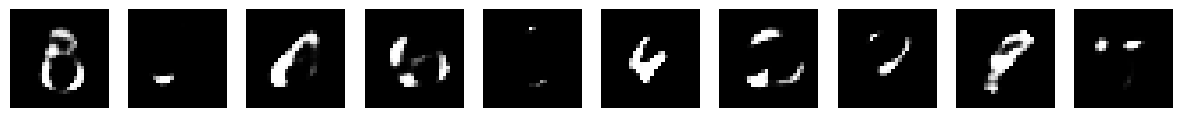

In [8]:
import matplotlib.pyplot as plt

# Generate new samples
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        generated_samples = model.decode(z)
    return generated_samples

# Generate and display new samples
num_samples = 10
generated_samples = generate_samples(model, num_samples)

# Reshape and denormalize the generated samples
generated_samples = generated_samples.view(-1, 28, 28)
generated_samples = (generated_samples * 0.5) + 0.5  # Denormalize

# Plot the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples[i].cpu().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()


# generated dimages